In [1]:
# Notebook: Analysis Example - MCPA 911
# Author: Thomas Purk
# Date: 2025-03-27
# Reference: 

# Analysis Example

With a best estimator model in hand from a grid search optimization step, use the model to estimate future activity, and distribute new vehicle resources accross the member townships.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emergency-911-calls-mcpa/911-processed.csv
/kaggle/input/emergency-911-calls-mcpa/911.csv
/kaggle/input/emergency-911-calls-mcpa/bes_rfr_model.pkl
/kaggle/input/emergency-911-calls-mcpa/911-encoded.csv
/kaggle/input/emergency-911-calls-mcpa/rfr_model.pkl


In [6]:
# Notebook Step up steps

# SciKit Learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

# For loading models
import pickle

# Prevent Pandas and other warnings from displaying above outputcells, improve readability
import warnings
warnings.filterwarnings('ignore')

# Load visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load the data 
df_in_path = '/kaggle/input/emergency-911-calls-mcpa/911-processed.csv'
df_911 = pd.read_csv(df_in_path)
df_911.info() # validate

# Load the model - Start here unless model needs to be recreated
with open('/kaggle/input/emergency-911-calls-mcpa/bes_rfr_model.pkl', 'rb') as f:
    rfr_model = pickle.load(f)

rfr_model

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649696 entries, 0 to 649695
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   twp           649696 non-null  object
 1   e             649696 non-null  int64 
 2   service_type  649696 non-null  object
 3   service_desc  649696 non-null  object
 4   month         649696 non-null  int64 
 5   day_of_week   649696 non-null  int64 
 6   day_night     649696 non-null  object
dtypes: int64(3), object(4)
memory usage: 34.7+ MB


RandomForestRegressor(max_features='auto', min_samples_leaf=4,
                      min_samples_split=10, random_state=42, verbose=2)

In [7]:
# Usage Example
# Assumption - The model predicts event counts per calander year
# Assumption - Each township currently has enough vehicles to cover historical call value
# Assumption - New vehicles are applied to cover a 5% increase in each type of call volume
# Assumption - One car is needed for evey 100 calls

from scipy.optimize import linprog

In [21]:
# Prepare the data

# Create a dataframe containing the current vehicle counts
# Group the data to get unique combinations of the following columns.
# NOTE: The model was trained on these categories
# This will goal is to have the model predict how many calls of each category
# will be received for the coming year

# Columns of interest 
cols = ['twp', 'month', 'day_of_week','day_night', 'service_type', 'service_desc']
df_911_sub = df_911[cols]

# Grouping - This dataframe represents the future records we need to predict call counts for
group_911 = df_911_sub.groupby(cols)
# Group then drop call_count. WE
df_911_grouped = group_911.size().reset_index(name='legacy_call_count')
df_911_grouped.drop(
    labels='legacy_call_count',
    axis='columns',
    inplace=True
)

# One-hot encode categorical features
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_features = encoder.fit_transform(df_911_grouped)

# Convert encoded features to a DataFrame
df_911_encoded = pd.DataFrame(
    data=encoded_features, 
    columns=encoder.get_feature_names_out()
)


In [56]:
# Make prediction for next year's call counts
predicted_calls = rfr_model.predict(df_911_encoded)

# Assume call volume will grow by 5% accross the board
# The analysis should determine how to distribute new vehicles to cover new calls
# Append the prediction back to the data
df_911_grouped['predicted_call_growth'] = (predicted_calls * 0.10)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.9s


In [57]:
# Arrange the data for the analysis

# Group by  twp, service_type and sum predicted_call_growth
df_demand_growth = df_911_grouped[['twp','service_type','predicted_call_growth']]
# Grouping
df_demand_growth = df_demand_growth.groupby(['twp','service_type']).sum().reset_index()
df_demand_growth

,twp,service_type,predicted_call_growth
0,ABINGTON TOWNSHIP,EMS,1459.030500
1,ABINGTON TOWNSHIP,Fire,445.562216
2,ABINGTON TOWNSHIP,Traffic,936.532398
3,AMBLER BOROUGH,EMS,281.251132
4,AMBLER BOROUGH,Fire,103.290845
...,...,...,...
181,WHITPAIN TOWNSHIP,Fire,213.247122
182,WHITPAIN TOWNSHIP,Traffic,482.072155
183,WORCESTER TOWNSHIP,EMS,299.734721
184,WORCESTER TOWNSHIP,Fire,110.622800


In [172]:
# How many townships are there?
twp_count = df_911_twp_grouped['twp'].nunique()

# Call per car
calls_per_vehicle = 250

# Define supply constraints
new_vehicles_police = 150
new_vehicles_fire = 150
new_vehicles_ems = 150

# Fair discribution constraints
min_vehicles_per_twp = 1
max_vehicles_per_twp = 5

predicted_calls_ems = df_demand_growth[df_demand_growth['service_type'] == 'EMS']['predicted_call_growth']
predicted_calls_traffic = df_demand_growth[df_demand_growth['service_type'] == 'Traffic']['predicted_call_growth']
predicted_calls_fire = df_demand_growth[df_demand_growth['service_type'] == 'Fire']['predicted_call_growth']

# Calls per vehicle per year = 2016
new_vehicle_demand_ems = predicted_calls_ems / calls_per_vehicle
new_vehicle_demand_traffic = predicted_calls_traffic / calls_per_vehicle
new_vehicle_demand_fire = predicted_calls_fire / calls_per_vehicle

# Bounds for variables (x1 >= 0, x2 >= 0)
# Each township gets at least 0
x_bounds = [(min_vehicles_per_twp, max_vehicles_per_twp) for _ in range(twp_count)]

# Linear Programming to optimize allocation
ems_results = linprog(
    c=-new_vehicle_demand_ems,  # We want to maximize allocations where demand is high
    A_ub=[ [1] * twp_count],  # Ensure all vehicles are allocated
    b_ub=[new_vehicles_ems],
    bounds=x_bounds,
    method='simplex'
)

tracffic_results = linprog(
    c=-new_vehicle_demand_traffic,  # We want to maximize allocations where demand is high
    A_ub=[ [1] * twp_count],  # Ensure all vehicles are allocated
    b_ub=[new_vehicles_police],
    bounds=x_bounds,
    method='simplex'
)

fire_results = linprog(
    c=-new_vehicle_demand_fire,  # We want to maximize allocations where demand is high
    A_ub=[ [1] * twp_count],  # Ensure all vehicles are allocated
    b_ub=[new_vehicles_fire],
    bounds=x_bounds,
    method='simplex'
)


df_allocations = pd.DataFrame(
    { 
        'twp': df_911_twp_grouped['twp'].unique(),
        'ems_allocation': ems_results.x,
        'ems_demand': list(new_vehicle_demand_ems),
        'traffic_allocation': tracffic_results.x,
        'traffic_demand': list(new_vehicle_demand_traffic),
        'fire_allocation': fire_results.x,
        'fire_demand': list(new_vehicle_demand_fire)
    })

print(df_allocations.to_string())

                          twp  ems_allocation  ems_demand  traffic_allocation  traffic_demand  fire_allocation  fire_demand
0           ABINGTON TOWNSHIP             5.0    5.836122                 5.0        3.746130              5.0     1.782249
1              AMBLER BOROUGH             1.0    1.125005                 1.0        0.421720              1.0     0.413163
2          BRIDGEPORT BOROUGH             1.0    0.876504                 1.0        0.509290              1.0     0.242393
3          BRYN ATHYN BOROUGH             1.0    0.271697                 1.0        0.266632              1.0     0.131402
4         CHELTENHAM TOWNSHIP             5.0    5.757724                 5.0        4.542183              5.0     1.886799
5        COLLEGEVILLE BOROUGH             1.0    0.696540                 1.0        0.392012              1.0     0.214375
6        CONSHOHOCKEN BOROUGH             1.0    1.083875                 1.0        0.571793              5.0     0.735516
7       

In [161]:
len(new_vehicle_demand_traffic)

62

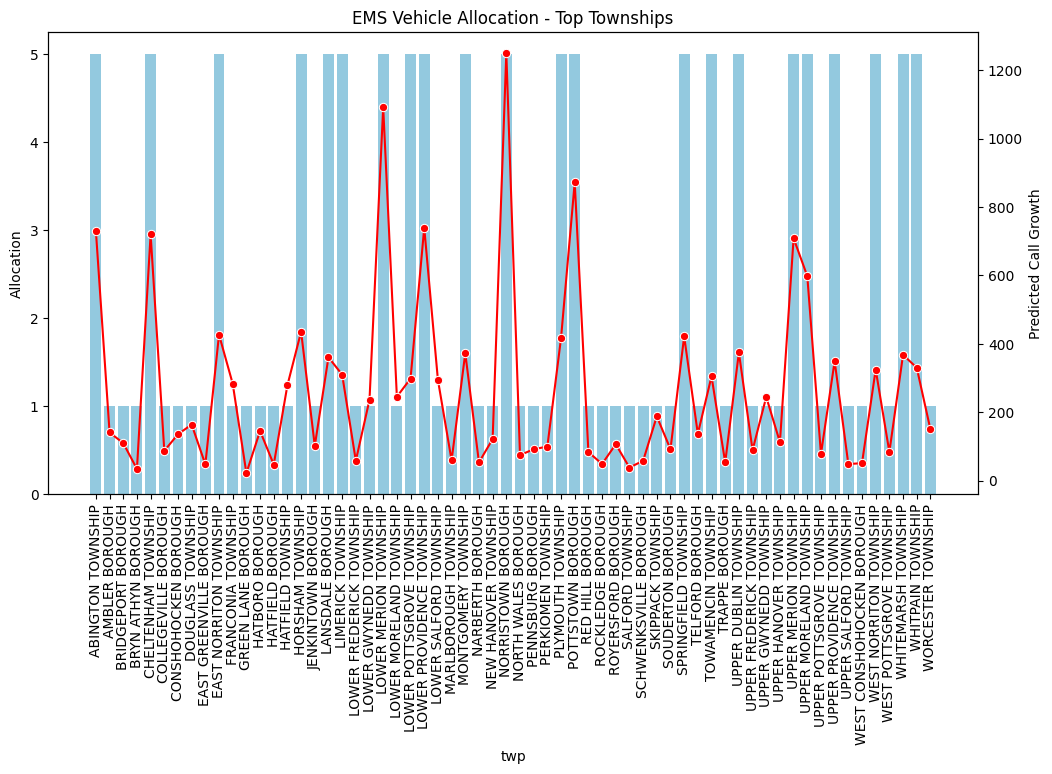

In [175]:
# Set up data - EMS
df_sub_ems = df_allocations[df_allocations['ems_allocation']  > 0]

df_sub_ems_growth = df_911_twp_grouped[
    (df_911_twp_grouped['twp'].isin(list(df_sub_ems['twp']))) &
    (df_911_twp_grouped['service_type'] == 'EMS')
]

# Set figure size
# Create first plot axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# 
sns.barplot(
    data=df_sub_ems,
    x='twp', 
    y='ems_allocation',
    ax=ax1,
    color='skyblue'
)

# Create the Second plot axis
ax2 = ax1.twinx()
sns.lineplot(
    data=df_sub_ems_growth,
    x="twp",
    y="predicted_call_growth",
    marker="o",
    color="red",
    ax=ax2
)


ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_ylabel('Allocation')
ax2.set_ylabel('Predicted Call Growth')
plt.title('EMS Vehicle Allocation - Top Townships')

plt.show()

,twp,service_type,predicted_call_growth
0,ABINGTON TOWNSHIP,EMS,729.515250
12,CHELTENHAM TOWNSHIP,EMS,719.715488
27,EAST NORRITON TOWNSHIP,EMS,426.470052
45,HORSHAM TOWNSHIP,EMS,435.270700
63,LOWER MERION TOWNSHIP,EMS,1091.348819
72,LOWER PROVIDENCE TOWNSHIP,EMS,739.291659
90,NORRISTOWN BOROUGH,EMS,1249.803994
102,PLYMOUTH TOWNSHIP,EMS,416.527811
105,POTTSTOWN BOROUGH,EMS,871.667529
129,SPRINGFIELD TOWNSHIP,EMS,421.549204


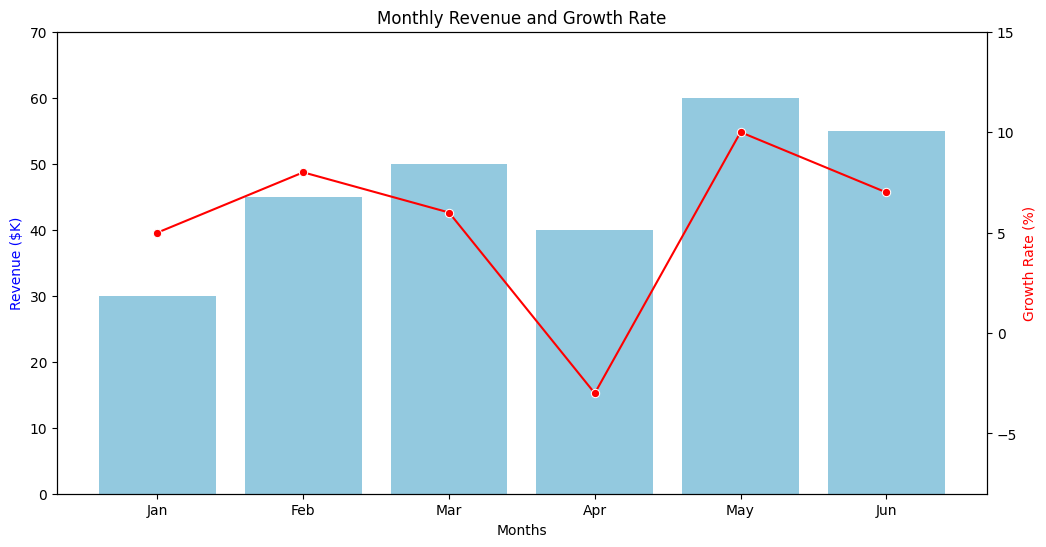

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create DataFrame
data = {
    "Month": ["Jan", "Feb", "Mar", "Apr", "May", "Jun"],
    "Revenue": [30, 45, 50, 40, 60, 55],
    "Growth Rate": [5, 8, 6, -3, 10, 7]
}

df = pd.DataFrame(data)

# Set figure size
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create bar plot (Revenue)
sns.barplot(x="Month", y="Revenue", data=df, color="skyblue", ax=ax1)
ax1.set_ylabel("Revenue ($K)", color="blue")
ax1.set_ylim(0, max(df["Revenue"]) + 10)  # Adjust y-axis limit

# Create second y-axis for Growth Rate
ax2 = ax1.twinx()  
sns.lineplot(x="Month", y="Growth Rate", data=df, marker="o", color="red", ax=ax2)
ax2.set_ylabel("Growth Rate (%)", color="red")
ax2.set_ylim(min(df["Growth Rate"]) - 5, max(df["Growth Rate"]) + 5)  # Adjust y-axis limit

# Add labels and title
plt.title("Monthly Revenue and Growth Rate")
ax1.set_xlabel("Months")

# Show the plot
plt.show()

